<br><u><font color='darkred' size=8>Disaster Tweets Classification</font></u>

<b>Twitter is an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programmatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

In this notebook, we’re going to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. We have access to a dataset of 10,000 tweets that were hand classified. 
    
Disclaimer: The dataset in this noetbook contains text that may be considered profane, vulgar, or offensive.</b>

# <font color='darkred'>Data Cleaning and Data Wrangling</font>

In [1]:
# importing basic dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import string
warnings.filterwarnings('ignore')

In [2]:
# loading the training data
df=pd.read_csv('train.csv')

# peek into the training data
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [4]:
# checking for NaNs
df.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [5]:
# checking if id is a unique identifier
df.id.duplicated().sum()

0

In [6]:
# dropping the id as it is merely a unique identifier
df.drop(['id'], axis=1, inplace=True)

In [7]:
# dropping the location as it contains many NaNs and also the disaster can happen in any place
df.drop(['location'], axis=1, inplace=True)

In [8]:
# dropping keyword as it most likely a keyword included by a human while hand labeling these tweets
df.drop(['keyword'], axis=1, inplace=True)

In [9]:
#checking if there are empty space texts
(df.text.str.isspace()).sum()

0

In [10]:
# checking the balancedness of the data
df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

<b>Though the classes are not perfectly balanced, it is not highly imbalanced either. Still we can apply SMOTE technique to balance the classes</b>

# <font color='darkred'>Setting Up The Pipeline</font>

In [11]:
# for splitting the data
from sklearn.model_selection import train_test_split

# for vectorizing the texts
from sklearn.feature_extraction.text import TfidfVectorizer

# for balancing the dataset
from imblearn.over_sampling import SMOTE

# for sequencing the tasks
from imblearn.pipeline import Pipeline

# for HPT and validation
from sklearn.model_selection import GridSearchCV

# learning algo for classification
from sklearn.svm import SVC

In [12]:
# instantiating the tfidf vectorizer
tfidf=TfidfVectorizer(stop_words='english') 

# instantiating the SMOTE object
smote=SMOTE(n_jobs=-1)

# instantiating the SVM object
svm=SVC(probability=True)

# defining the sequence of operations
steps=[('tfidf',tfidf),('smote',smote),('svm',svm)]

# instantiating the pipeline object
pipe=Pipeline(steps=steps)

# defining the parameter grid for HPT
param_grid={'svm__C':np.logspace(-2,2,100)}

# instantiating the gridsearchCV object
grid=GridSearchCV(estimator=pipe, 
                  param_grid=param_grid, 
                  cv=5, 
                  scoring='f1', 
                  n_jobs=-1)

In [13]:
# creating UDF to remove punctuations
def remove_punct(txt):
    no_punct=''.join([char for char in txt if char not in string.punctuation])
    return no_punct

# vectorizing the above UDF to make it more efficient
remove_punct=np.vectorize(remove_punct)

In [14]:
# applying the above UDF to remove the punctuations from all the texts
df.text=df.text.apply(remove_punct)

In [15]:
X=df.text # predictor variable which is yet to be vectorized numerically
y=df.target # target variable

In [16]:
# splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# <font color='darkred'>Training the Support Vector Machine using the Radial Basis Function Kernel</font>

In [17]:
# training the algorithm on the data
grid.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(stop_words='english')),
                                       ('smote', SMOTE(n_jobs=-1)),
                                       ('svm', SVC(probability=True))]),
             n_jobs=-1,
             param_grid={'svm__C': array([1.00000000e-02, 1.09749877e-02, 1.20450354e-02, 1.32194115e-02,
       1.45082878e-02, 1.59228279e-02, 1.74752840e-02, 1.91791026e-02,
       2.10490414e-02, 2.31012970e-02, 2.53536449e...
       1.17681195e+01, 1.29154967e+01, 1.41747416e+01, 1.55567614e+01,
       1.70735265e+01, 1.87381742e+01, 2.05651231e+01, 2.25701972e+01,
       2.47707636e+01, 2.71858824e+01, 2.98364724e+01, 3.27454916e+01,
       3.59381366e+01, 3.94420606e+01, 4.32876128e+01, 4.75081016e+01,
       5.21400829e+01, 5.72236766e+01, 6.28029144e+01, 6.89261210e+01,
       7.56463328e+01, 8.30217568e+01, 9.11162756e+01, 1.00000000e+02])},
             scoring='f1')

In [18]:
# this is the best estimator parameters
grid.best_params_

{'svm__C': 1.261856883066021}

In [19]:
# this is the best f1 score
grid.best_score_

0.7319359797201358

# <font color='darkred'>Model Performance Evaluation</font>
<b>Now we're going to <font color='darkred'>evaluate</font> the <font color='darkred'>performance</font> of this <font color='darkred'>model</font> on the <font color='darkred'>test set</font> and particularly we're going to choose an appropriate <font color='darkred'>probability threshold</font> to <font color='darkred'>optimize</font> for better <font color='darkred'>f1_score</font>.</b>

In [20]:
# predicting the class membership probability for class1
y_test_proba=grid.predict_proba(X_test)[:,1]
y_test_proba

array([0.77022145, 0.0381667 , 0.96149095, ..., 0.53890991, 0.99999948,
       0.16901798])

In [21]:
# making predictions off of the test set with default probability threshold of 50%
y_test_pred=grid.predict(X_test)
y_test_pred

array([1, 0, 1, ..., 0, 1, 0], dtype=int64)

In [22]:
# importing all relevant classification metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score

In [23]:
# the following metrics are w.r.t default probability threshold of 50%
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.80      0.89      0.84       869
           1       0.83      0.70      0.76       654

    accuracy                           0.81      1523
   macro avg       0.82      0.80      0.80      1523
weighted avg       0.81      0.81      0.81      1523



<b>Note that the <font color='darkred'>accuracy</font> is not very high, because the whole objective of this problem is to maximize <font color='darkred'>f1_score</font></b>

In [24]:
fpr,tpr,thresholds=roc_curve(y_test,y_test_proba,drop_intermediate=False)
auc=round(100*roc_auc_score(y_test,y_test_proba),2)
print(f'AUC={auc}')

AUC=85.69


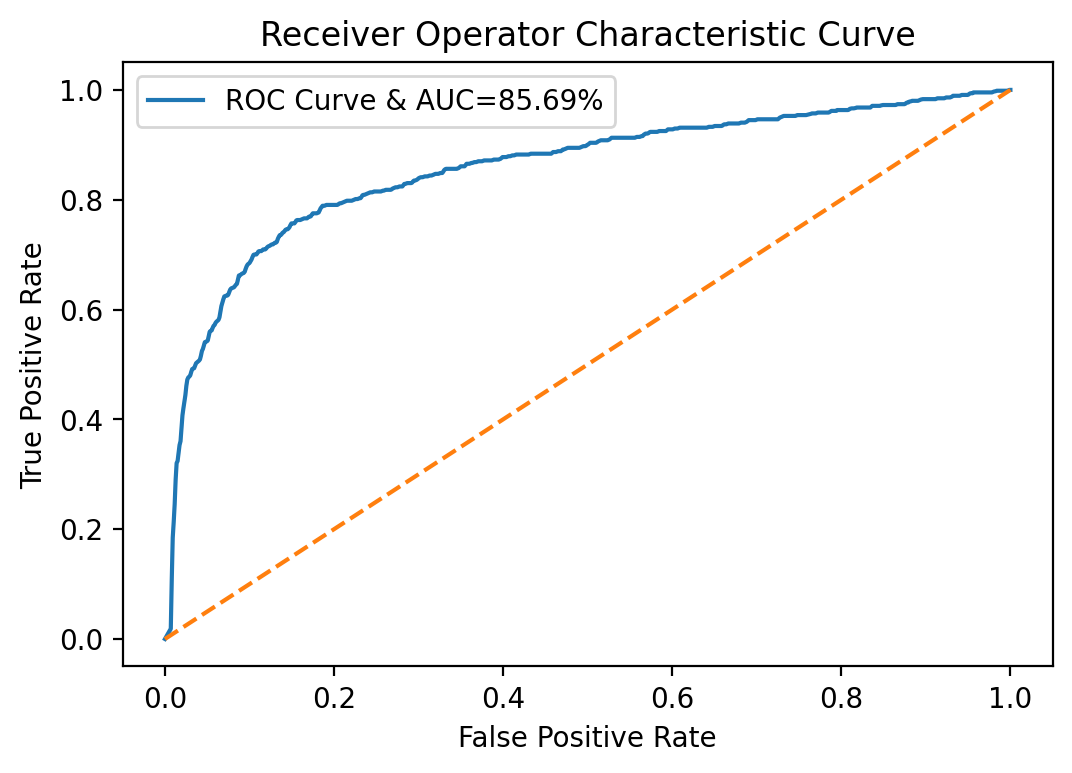

In [42]:
plt.figure(dpi=200)
plt.title('Receiver Operator Characteristic Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
sns.lineplot(x=fpr,y=tpr, label='ROC Curve & AUC=85.69%')
sns.lineplot(np.linspace(0,1,100),np.linspace(0,1,100), ls='--');

<b>We know that farther the <font color='darkred'>ROC curve</font> is from the line <font color='darkred'>y=x</font> the better our model is. In that sense, we have a really good model and the <font color='darkred'>auc_score</font> is <font color='darkred'>85.69%</font> which is good.

Let us now plot the graph of <font color='darkred'>precision vs threshold</font>, <font color='darkred'>recall vs threshold</font> and <font color='darkred'>f1_score vs threshold</font> on the same graph. Let us come up with a short and evenly spaced new array of <font color='darkred'>threshold values</font> and compute the above 3 metrics off of them.</b>

In [26]:
# creating 100 probability thresholds using linspace
threshold_list=np.linspace(0,1,100)

# creating lists to contain accuracy, sensitivity and specificity
precisions, recalls, f1s=[], [], []

for i in threshold_list:
    
    # making predictions for every choice of threshold
    y_tmp=np.array([1 if num>i else 0 for num in y_test_proba])
    
    # appending the precision_score for the above prediction
    precisions.append(precision_score(y_test,y_tmp))
    
    # appending the recall_score for the above prediction
    recalls.append(recall_score(y_test,y_tmp))
    
    # appending the f1_score for the above prediction
    f1s.append(f1_score(y_test,y_tmp))

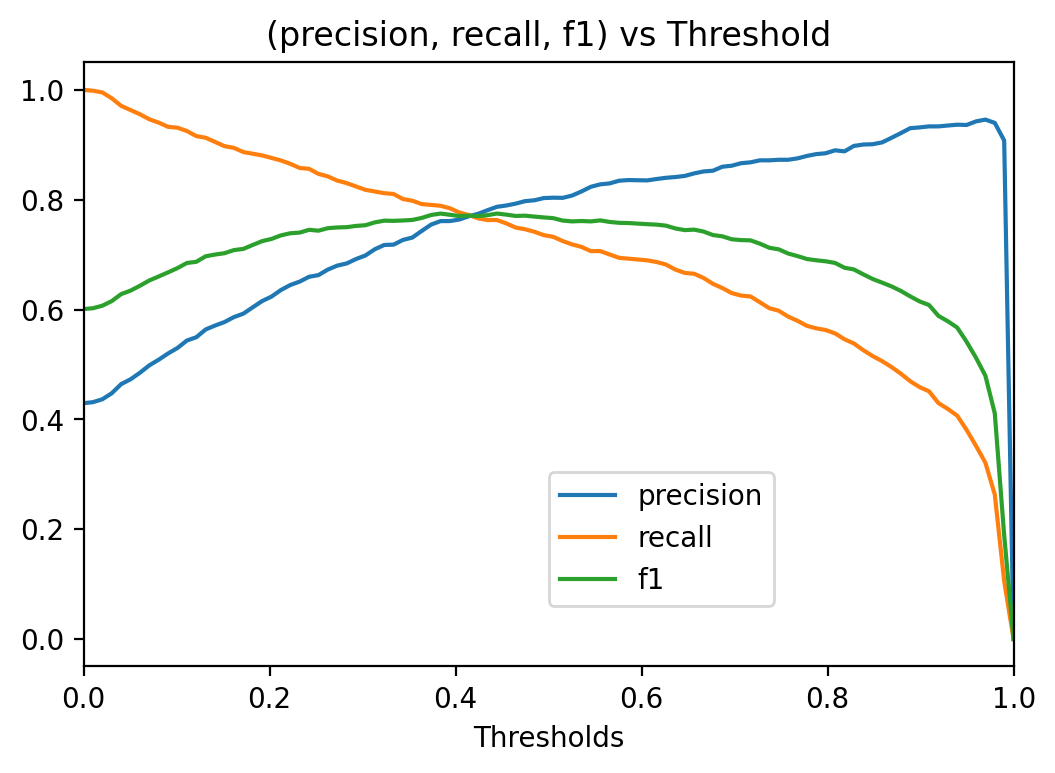

In [27]:
# plotting the curves using the metrics we've computed
plt.figure(dpi=200)
plt.title('(precision, recall, f1) vs Threshold')
plt.xlabel('Thresholds')
plt.xlim((0,1))
sns.lineplot(x=threshold_list,y=precisions, label='precision')
sns.lineplot(x=threshold_list,y=recalls, label='recall')
sns.lineplot(x=threshold_list,y=f1s, label='f1')
plt.legend(loc=(0.5,0.1));

In [28]:
# finding the highest possible f1_score using linear scan
idx=-1
max_f1=-1
for i,num in enumerate(f1s):
    if num>max_f1:
        max_f1=num
        idx=i

In [29]:
# finding the optimal threshold
optimal_thres=threshold_list[idx]
optimal_thres

0.4444444444444445

In [30]:
# making classification using 0.4444 as threshold
y_test_pred=np.array([1 if prob>optimal_thres else 0 for prob in y_test_proba])

<b>Though we've already computed all the important metrics such as <font color='darkred'>precision</font>, <font color='darkred'>recall</font> and <font color='darkred'>f1_score</font>. We've computed them based on an arbitrarily chosen <font color='darkred'>probability threshold</font> value of <font color='darkred'>0.5</font>. Later on using <font color='darkred'>ROC curve</font> and other <font color='darkred'>metric curves</font>, we've decided to choose <font color='darkred'>probability threshold</font> of <font color='darkred'>0.4444</font> to optimize for better <font color='darkred'>f1_score</font>. Now we need to re-compute all the above metrics for the <font color='darkred'>test set</font> using the new value <font color='darkred'>0.4444</font> to understand the model performance.</b>

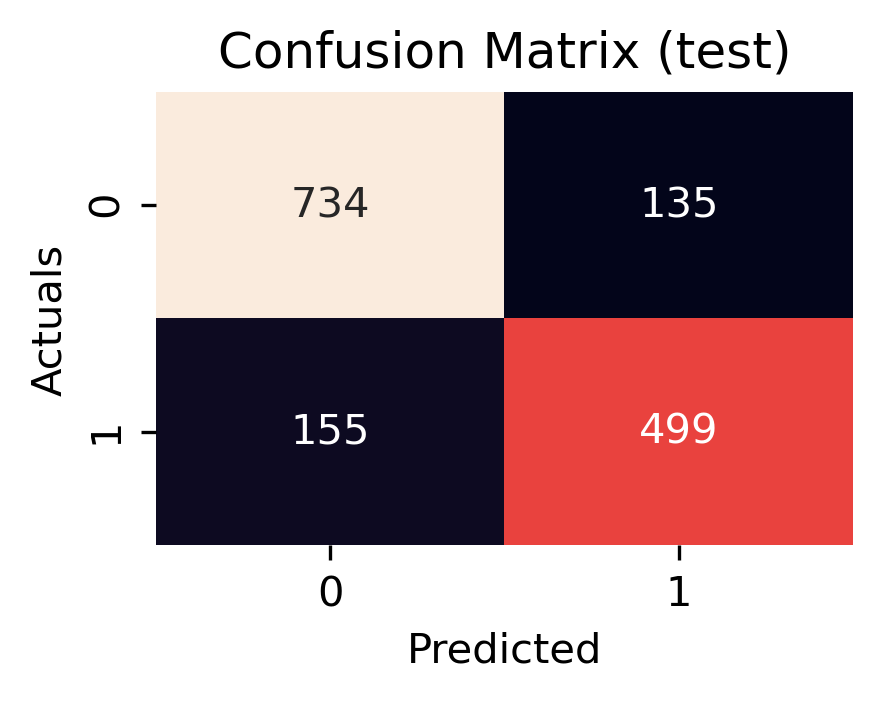

In [31]:
# determining the confusion matrix for test set
plt.figure(figsize=(3,2),dpi=300)
plt.title('Confusion Matrix (test)')
confusion_test=confusion_matrix(y_test,y_test_pred)
sns.heatmap(confusion_test, annot=True, cbar=False, fmt='.5g')
plt.xlabel('Predicted')
plt.ylabel('Actuals');

In [32]:
# TN: True Negative
TN_test=confusion_test[0,0]

# FP: False Positive
FP_test=confusion_test[0,1]

# FN: False Negative
FN_test=confusion_test[1,0]

# TP: True Positive
TP_test=confusion_test[1,1]

In [33]:
# checking the metrics for the test set
accuracy_test=accuracy_score(y_test,y_test_pred)
sensitivity_test=TP_test/(TP_test+FN_test) 
specificity_test=TN_test/(TN_test+FP_test)
precision_test=precision_score(y_test,y_test_pred)
recall_test=recall_score(y_test,y_test_pred) # by definition recall=sensitivity
f1_test=f1_score(y_test,y_test_pred)

# <font color='darkred'>Classification Metrics</font>

In [34]:
# representing all the above metrics in a dataframe
metrics=pd.DataFrame()
metrics['metrics']=['Accuracy','Sensitivity','Specificity','Precision','Recall','f1']
metrics['test %']=np.round(100*np.array([accuracy_test,sensitivity_test,specificity_test,precision_test,recall_test,f1_test]),2)

metrics.set_index('metrics')

,test %
metrics,
Accuracy,80.96
Sensitivity,76.30
Specificity,84.46
Precision,78.71
Recall,76.30
f1,77.48


# <font color='darkred'>Making Predictions Using The Unseen Test Set</font>

In [35]:
# loading the unseen dataset
unseen=pd.read_csv('test.csv')

In [36]:
# removing the punctuations from the texts
X_unseen=unseen.text.apply(remove_punct)

In [37]:
# predicting class membership probability for class1 using pre-trained model grid
y_unseen_proba=grid.predict_proba(X_unseen)[:,1]
y_unseen_proba

array([0.58484317, 0.75696678, 0.83310658, ..., 0.92324351, 0.98015097,
       0.6470902 ])

In [38]:
# making class predictions 
unseen_pred=[1 if num>optimal_thres else 0 for num in y_unseen_proba]

In [39]:
unseen['target']=unseen_pred

In [40]:
# extracting only the id and the target
unseen=unseen[['id','target']]

# <font color='darkred'>Final Submission: Output File</font>

In [41]:
# creating the csv file for submission
unseen.to_csv('submission.csv')